<a href="https://colab.research.google.com/github/RodMendez/Estad-stica/blob/main/Densidades_de_entropias_superficiales_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.regularizers import l2  #para evitar el sobreajuste

In [2]:
data = pd.read_csv("Mayor R  (R500).csv")

Detección de outliers

In [4]:
# Convertir las columnas relevantes a tipo numérico
numeric_columns = data.columns.drop(['Nombre', 'A', 'CC'])  # Excluimos 'Name' de la conversión numérica
data_numeric = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Calcular el rango intercuartílico (IQR) para cada columna numérica
Q1 = data_numeric.quantile(0.25)
Q3 = data_numeric.quantile(0.75)
IQR = Q3 - Q1

# Definir un umbral para identificar outliers
threshold = 3

# Función para identificar outliers en una fila
def identify_outliers(row):
    outliers = []
    for col in data_numeric.columns:
        if row[col] < (Q1[col] - threshold * IQR[col]) or row[col] > (Q3[col] + threshold * IQR[col]):
            outliers.append(col)
    return outliers if outliers else np.nan

# Aplicar la función a cada fila y crear una nueva columna con la lista de variables outlier
data['outlier_vars'] = data_numeric.apply(identify_outliers, axis=1)

# Filtrar solo las filas que contienen outliers
outliers_data = data[data['outlier_vars'].notna()]

# Imprimir los resultados
for _, row in outliers_data.iterrows():
    print(f"Cúmulo: {row['Nombre']}")
    print(f"Variables outlier: {', '.join(row['outlier_vars'])}")
    print("Valores:")
    for var in row['outlier_vars']:
        print(f"  {var}: {row[var]}")
    print("\n")


Cúmulo: ABELL_0426                
Variables outlier: nelec
Valores:
  nelec: 0.0127


Cúmulo: ABELL_1060                
Variables outlier: nelec
Valores:
  nelec: 0.0128


Cúmulo: ABELL_2199                
Variables outlier: nelec
Valores:
  nelec: 0.104


Cúmulo: ABELL_4038                
Variables outlier: Rmax rayos X, nelec
Valores:
  Rmax rayos X: 4.0
  nelec: 0.0116




Eliminamos los outliers (por ahora)

In [5]:
# Crear DataFrame limpio sin outliers
clean_df = data[data['outlier_vars'].isna()].drop(columns=['outlier_vars'])


In [ ]:
pd.set_option('display.max_columns', None)  # Esto permite ver todas las columnas
pd.set_option('display.expand_frame_repr', False)  # Esto impide que las columnas se corten
resumen =clean_df.describe()
print("Resumen estadístico")
print(resumen)

Resumen estadístico
       Rmax rayos X      nelec         Tx            S         σLOS       Rvir       Mvir         Hz       R500
count     34.000000  34.000000  34.000000    34.000000    34.000000  34.000000  34.000000  34.000000  33.000000
mean       0.340868   0.002499   5.097941   367.732353   838.411765   2.040235  10.269706  15.659412   1.037233
std        0.196890   0.001614   2.225924   260.751849   198.016546   0.431768   5.562410   0.694890   0.173958
min        0.075200   0.000709   1.620000    98.900000   343.000000   0.870000   0.680000  13.470000   0.650500
25%        0.201000   0.001350   3.792500   189.500000   728.750000   1.822250   6.337500  15.410000   0.929800
50%        0.296000   0.002035   5.075000   261.000000   824.000000   2.022000   8.780000  15.710000   1.048000
75%        0.474250   0.003360   6.005000   490.250000   988.750000   2.398750  14.832500  16.160000   1.128800
max        1.050000   0.006800  10.900000  1060.000000  1222.000000   2.683000  20.6


Distribución de variables numéricas:


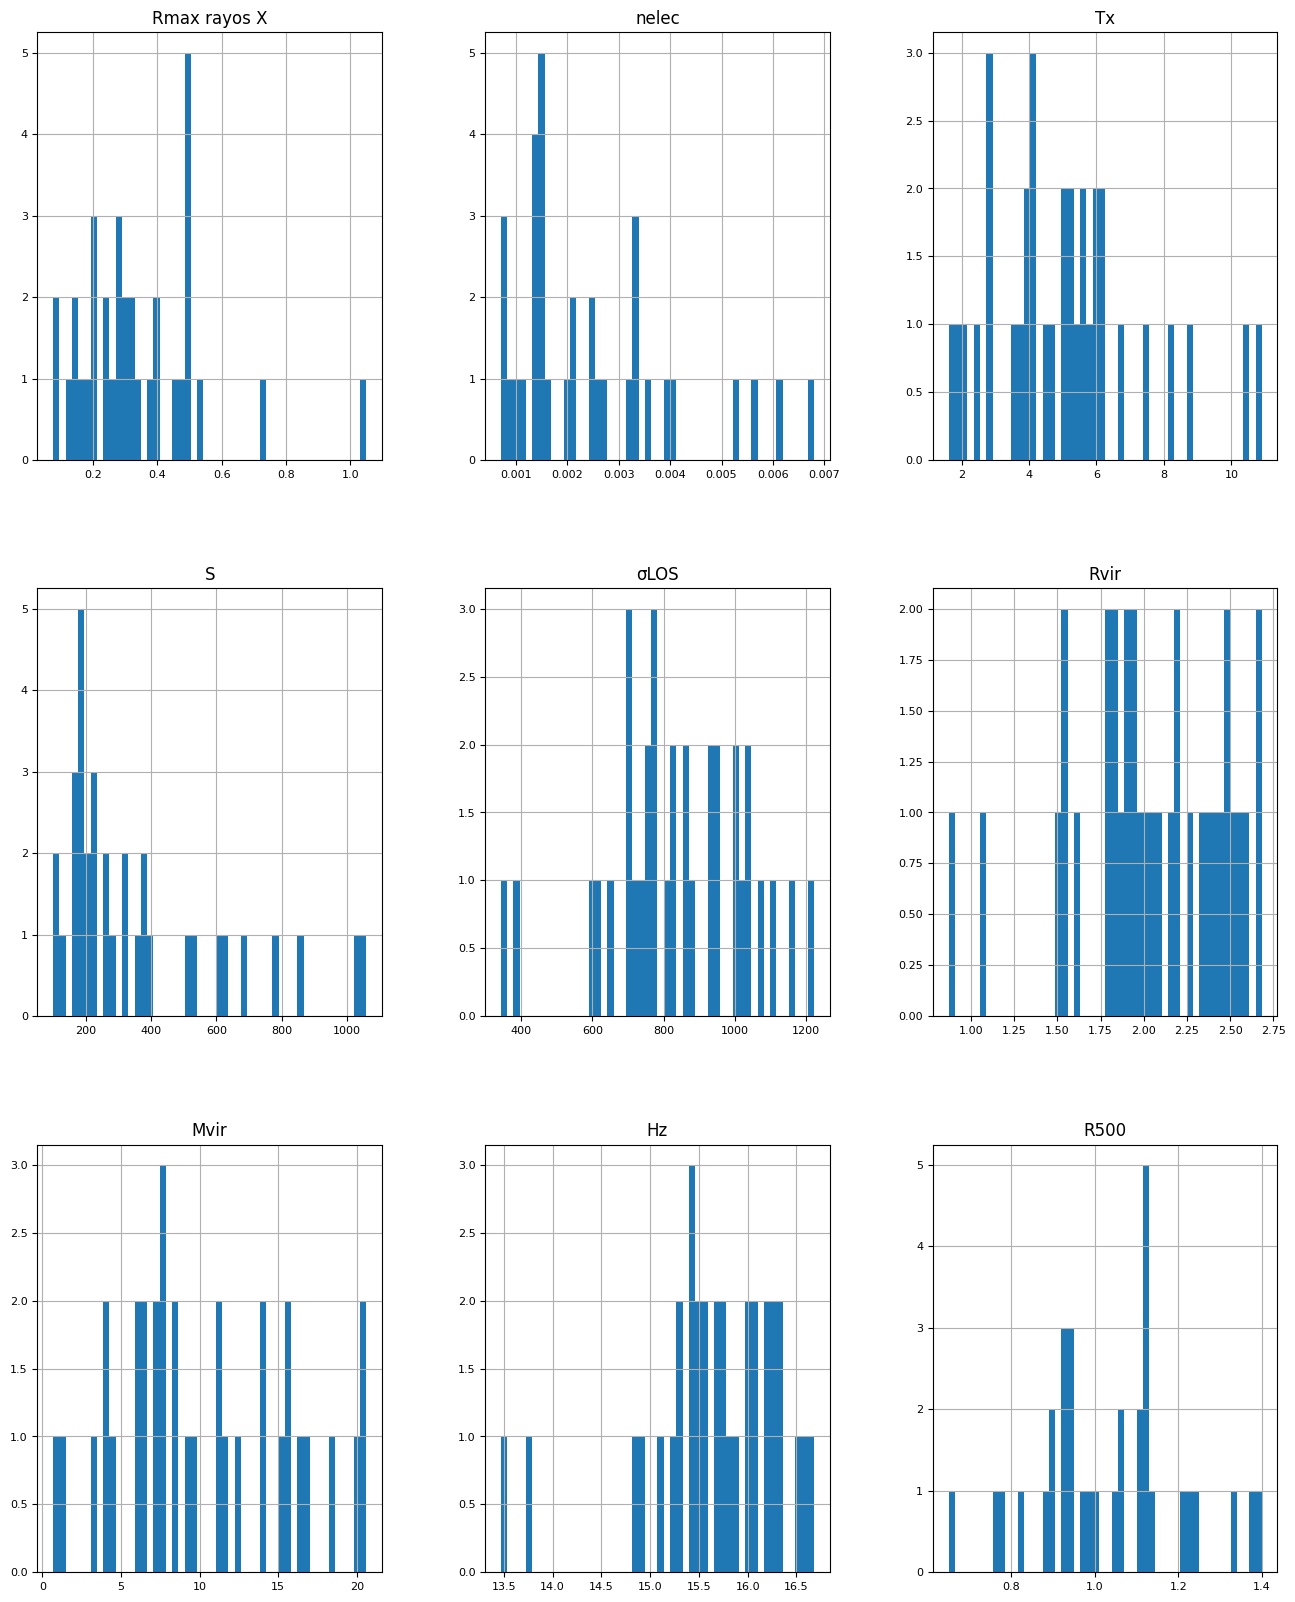

In [ ]:
# Distribución de cada variable
print("\nDistribución de variables numéricas:")
clean_df.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

Matriz de correlación con coeficiente de correlación  de Pearson.
Midiendo tambien correlación entre variables categóricas

CC_first es considerando solo la primera letra de la variable categórica CC, ej: Si tenemos W,s. Solo consideraremos W


Matriz de correlación:


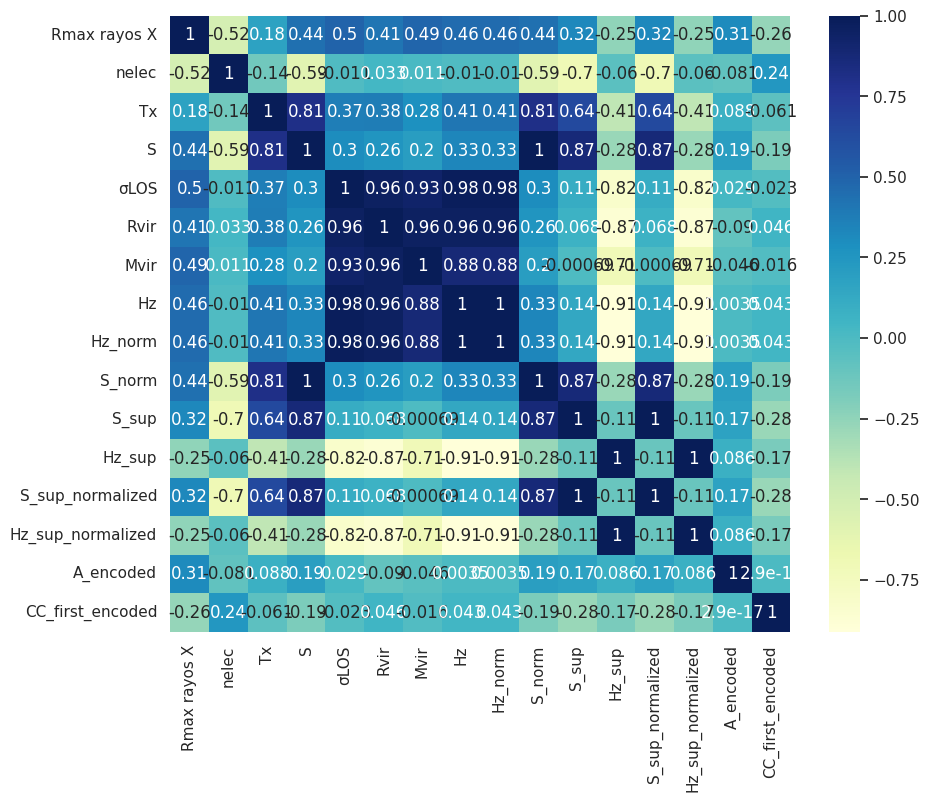

In [43]:
from sklearn.preprocessing import LabelEncoder

# Filtramos para considerar solo la primera letra de la columna 'CC'
clean_df['CC_first'] = clean_df['CC'].str[0]

# Inicializamos el codificador
label_encoder = LabelEncoder()

# Codificamos las variables categóricas
clean_df['A_encoded'] = label_encoder.fit_transform(clean_df['A'])
clean_df['CC_first_encoded'] = label_encoder.fit_transform(clean_df['CC_first'])

# Convertir las columnas relevantes a tipo numérico
clean_df_numeric = clean_df.apply(pd.to_numeric, errors='coerce')

# Agregar las columnas codificadas al DataFrame numérico
clean_df_numeric['A_encoded'] = clean_df['A_encoded']
clean_df_numeric['CC_first_encoded'] = clean_df['CC_first_encoded']

# Seleccionar solo las columnas relevantes para la matriz de correlación
columns_to_exclude = ['Nombre', 'A', 'CC', 'CC_first', 'R500', 'CC_encoded', 'A_numerico', 'CC_first_numerico']  # Añadimos las nuevas columnas a excluir
correlation_df = clean_df_numeric[[col for col in clean_df_numeric.columns if col not in columns_to_exclude]]

# Matriz de correlación
print("\nMatriz de correlación:")
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df.corr(), annot=True, cmap="YlGnBu")
plt.show()


Matriz de correlación de Spearman, para considerar relaciones no lineales.
En general, mejoran el coficiente, lo que indica que tenemos correlaciones no lineales en su mayoría.

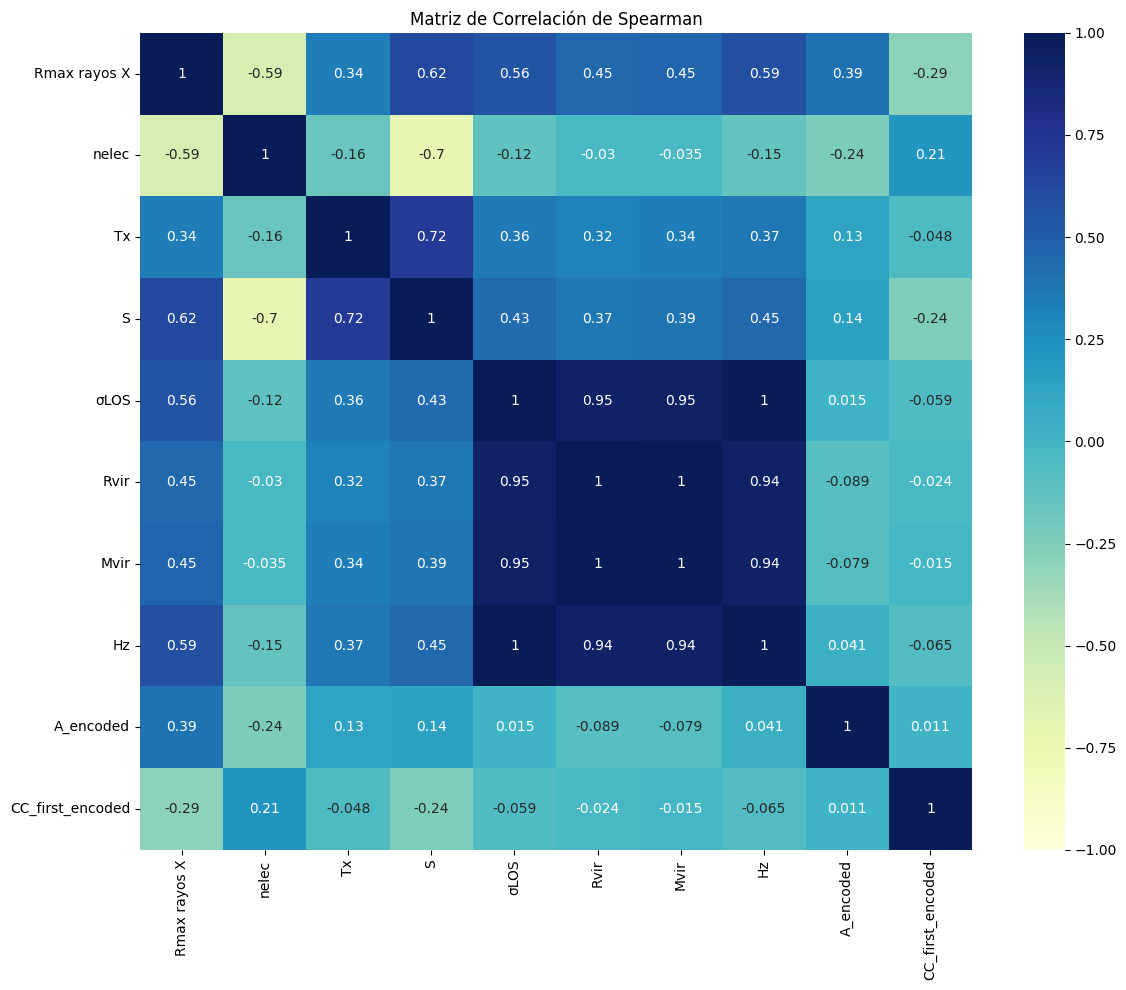

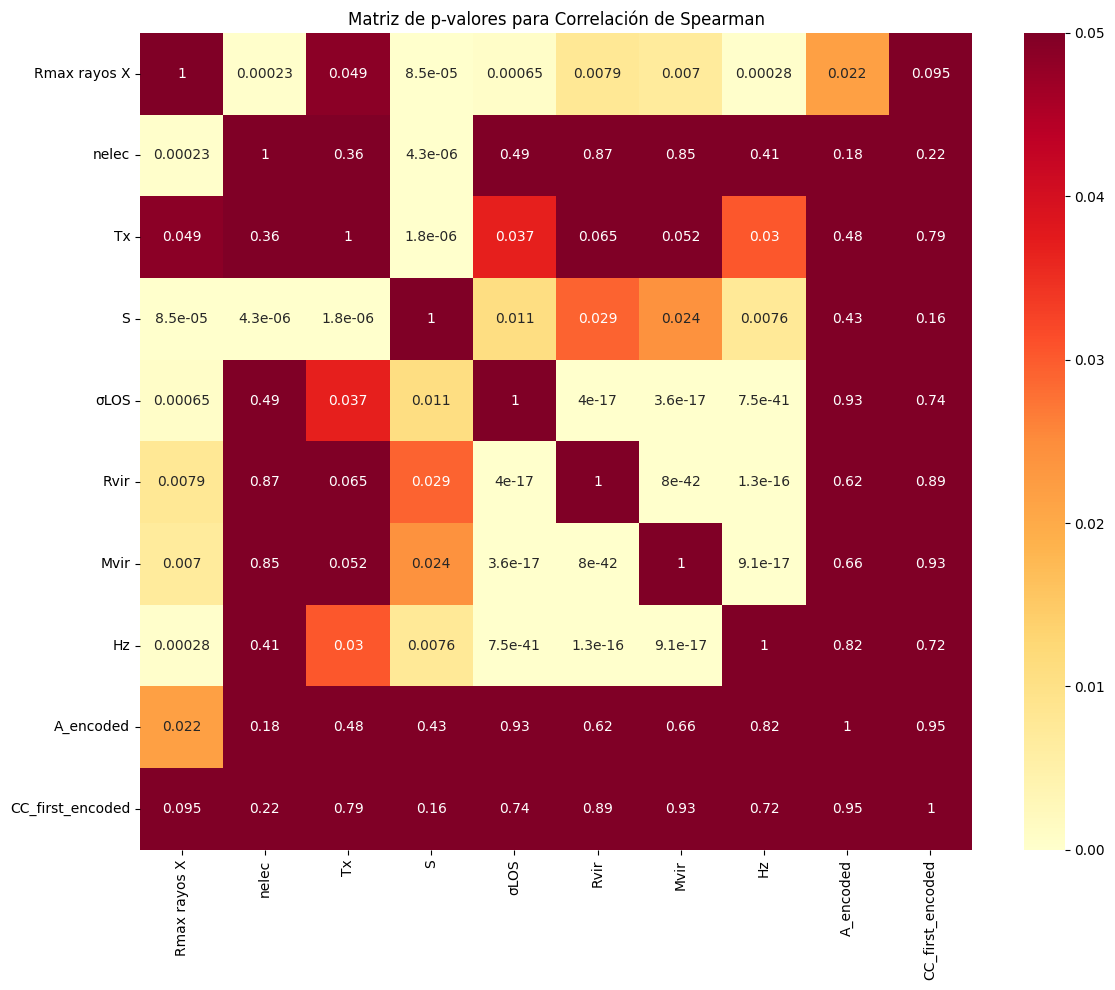


Correlaciones de Spearman significativas (p < 0.05):
nelec vs Rmax rayos X: correlación = -0.591, p-valor = 0.0002
Tx vs Rmax rayos X: correlación = 0.340, p-valor = 0.0488
S vs Rmax rayos X: correlación = 0.622, p-valor = 0.0001
S vs nelec: correlación = -0.699, p-valor = 0.0000
S vs Tx: correlación = 0.718, p-valor = 0.0000
σLOS vs Rmax rayos X: correlación = 0.555, p-valor = 0.0007
σLOS vs Tx: correlación = 0.360, p-valor = 0.0368
σLOS vs S: correlación = 0.432, p-valor = 0.0108
Rvir vs Rmax rayos X: correlación = 0.448, p-valor = 0.0079
Rvir vs S: correlación = 0.374, p-valor = 0.0292
Rvir vs σLOS: correlación = 0.945, p-valor = 0.0000
Mvir vs Rmax rayos X: correlación = 0.454, p-valor = 0.0070
Mvir vs S: correlación = 0.386, p-valor = 0.0241
Mvir vs σLOS: correlación = 0.946, p-valor = 0.0000
Mvir vs Rvir: correlación = 0.998, p-valor = 0.0000
Hz vs Rmax rayos X: correlación = 0.585, p-valor = 0.0003
Hz vs Tx: correlación = 0.372, p-valor = 0.0304
Hz vs S: correlación = 0.450, p-

In [ ]:
from scipy import stats

# Filtramos para considerar solo la primera letra de la columna 'CC'
clean_df['CC_first'] = clean_df['CC'].str[0]

# Inicializamos el codificador
label_encoder = LabelEncoder()

# Codificamos las variables categóricas
clean_df['A_encoded'] = label_encoder.fit_transform(clean_df['A'])
clean_df['CC_first_encoded'] = label_encoder.fit_transform(clean_df['CC_first'])

# Convertir las columnas relevantes a tipo numérico
clean_df_numeric = clean_df.apply(pd.to_numeric, errors='coerce')

# Agregar las columnas codificadas al DataFrame numérico
clean_df_numeric['A_encoded'] = clean_df['A_encoded']
clean_df_numeric['CC_first_encoded'] = clean_df['CC_first_encoded']

# Excluir columnas irrelevantes para la correlación
columns_to_exclude = ['Nombre', 'A', 'CC', 'CC_first', 'R500', 'CC_encoded','A_numerico', 'CC_first_numerico']  # Añadimos las columnas a excluir
correlation_df = clean_df_numeric[[col for col in clean_df_numeric.columns if col not in columns_to_exclude]]

# Calcular la matriz de correlación de Spearman
correlation_matrix = correlation_df.corr(method='spearman')

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", vmin=-1, vmax=1, center=0)
plt.title("Matriz de Correlación de Spearman")
plt.tight_layout()
plt.show()

# Función para calcular el p-valor para la correlación de Spearman
def spearman_pvalue(x, y):
    return stats.spearmanr(x, y)[1]

# Calcular matriz de p-valores
p_value_matrix = correlation_df.corr(method=spearman_pvalue)

# Visualizar la matriz de p-valores
plt.figure(figsize=(12, 10))
sns.heatmap(p_value_matrix, annot=True, cmap="YlOrRd", vmin=0, vmax=0.05)
plt.title("Matriz de p-valores para Correlación de Spearman")
plt.tight_layout()
plt.show()

# Imprimir correlaciones significativas
print("\nCorrelaciones de Spearman significativas (p < 0.05):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if p_value_matrix.iloc[i, j] < 0.05:
            print(f"{correlation_matrix.columns[i]} vs {correlation_matrix.columns[j]}: "
                  f"correlación = {correlation_matrix.iloc[i, j]:.3f}, "
                  f"p-valor = {p_value_matrix.iloc[i, j]:.4f}")


Dispersion y Ajuste lineal entre entropías

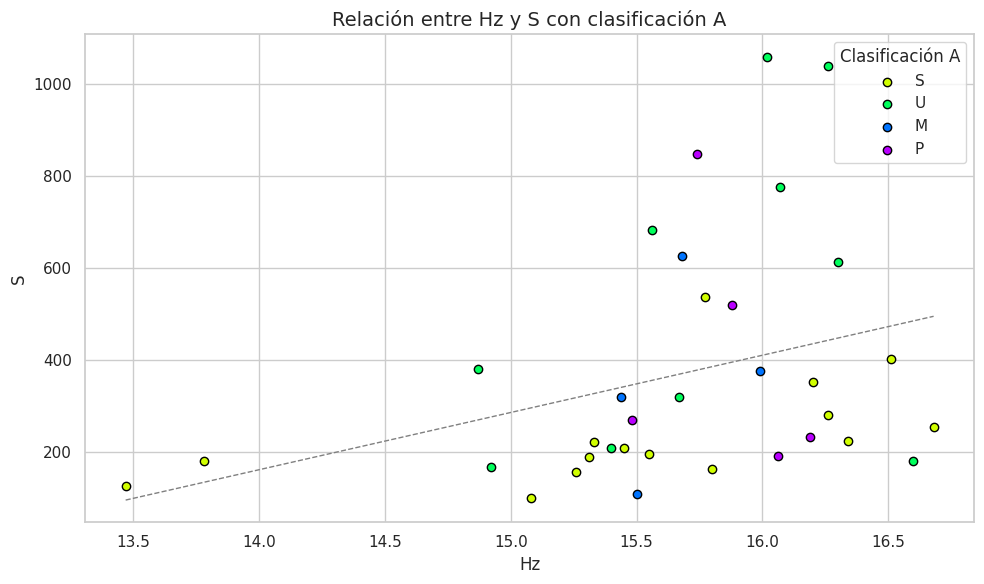

In [ ]:
# Configuración del estilo de seaborn
sns.set(style="whitegrid")

# Crear un mapa de colores basado en las categorías de A
unique_classes = clean_df['A'].unique()  # obtener las clases únicas de A
palette = sns.color_palette("hsv", len(unique_classes))  # generar una paleta de colores

# Crear la gráfica de dispersión
plt.figure(figsize=(10, 6))

for i, class_label in enumerate(unique_classes):
    # Filtrar los datos por cada clase de A
    class_data = clean_df[clean_df['A'] == class_label]

    # Graficar la dispersión para cada clase
    plt.scatter(class_data['Hz'], class_data['S'], label=class_label,
                color=palette[i], edgecolor='black')

# Ajuste lineal con Seaborn (opcional)
sns.regplot(x='Hz', y='S', data=clean_df, scatter=False, color='gray', ci=None,
            line_kws={"linewidth":1, "linestyle":"--"})

# Configurar el título y etiquetas
plt.title('Relación entre Hz y S con clasificación A', fontsize=14)
plt.xlabel('Hz', fontsize=12)
plt.ylabel('S', fontsize=12)

# Mostrar la leyenda
plt.legend(title='Clasificación A')

# Mostrar la gráfica
plt.tight_layout()
plt.show()



Dispersion y Ajuste no lineal entre entropias

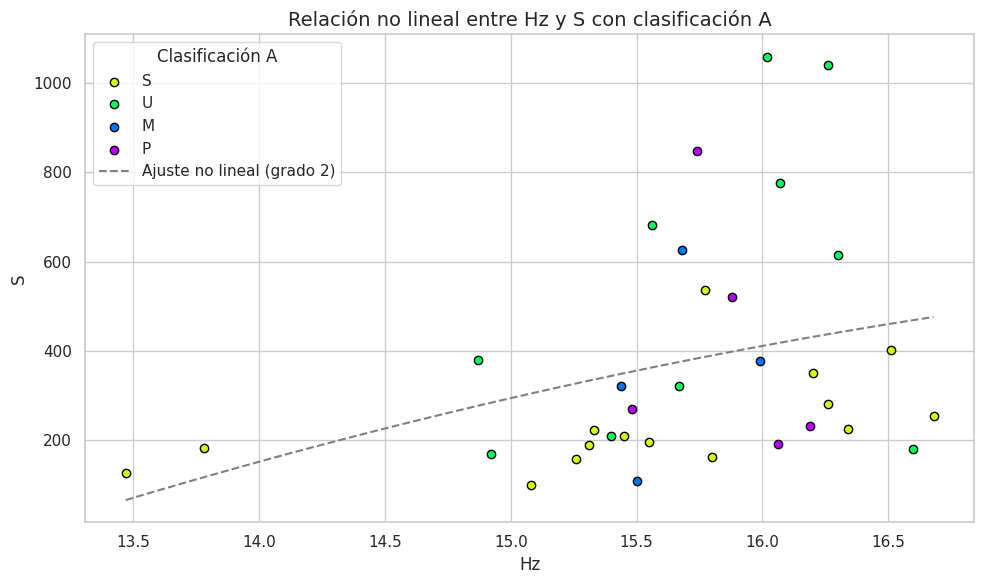

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración del estilo de seaborn
sns.set(style="whitegrid")

# Crear un mapa de colores basado en las categorías de A
unique_classes = clean_df['A'].unique()  # obtener las clases únicas de A
palette = sns.color_palette("hsv", len(unique_classes))  # generar una paleta de colores

# Crear la gráfica de dispersión
plt.figure(figsize=(10, 6))

for i, class_label in enumerate(unique_classes):
    # Filtrar los datos por cada clase de A
    class_data = clean_df[clean_df['A'] == class_label]

    # Graficar la dispersión para cada clase
    plt.scatter(class_data['Hz'], class_data['S'], label=class_label,
                color=palette[i], edgecolor='black')

# Ajuste no lineal: polinomio de segundo grado
# Coeficientes del ajuste polinómico (grado 2)
coef = np.polyfit(clean_df['Hz'], clean_df['S'], 2)

# Crear una función polinómica a partir de los coeficientes
poly_func = np.poly1d(coef)

# Generar valores de Hz para la curva ajustada
Hz_range = np.linspace(clean_df['Hz'].min(), clean_df['Hz'].max(), 500)
S_fitted = poly_func(Hz_range)

# Graficar la curva ajustada
plt.plot(Hz_range, S_fitted, color='gray', linestyle='--', label="Ajuste no lineal (grado 2)")

# Configurar el título y etiquetas
plt.title('Relación no lineal entre Hz y S con clasificación A', fontsize=14)
plt.xlabel('Hz', fontsize=12)
plt.ylabel('S', fontsize=12)

# Mostrar la leyenda
plt.legend(title='Clasificación A')

# Mostrar la gráfica
plt.tight_layout()
plt.show()


Ajuste considerando las entropías normalizadas

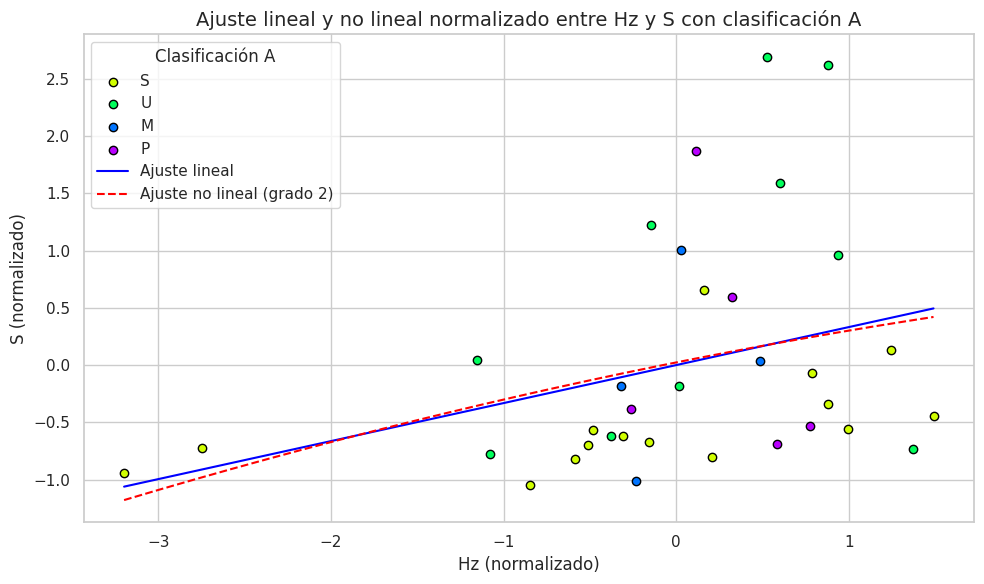

In [9]:
from sklearn.preprocessing import StandardScaler

# Configuración del estilo de seaborn
sns.set(style="whitegrid")

# Crear el escalador
scaler = StandardScaler()

# Normalizar las columnas de entropía (Hz y S)
clean_df[['Hz_norm', 'S_norm']] = scaler.fit_transform(clean_df[['Hz', 'S']])

# Crear un mapa de colores basado en las categorías de A
unique_classes = clean_df['A'].unique()  # obtener las clases únicas de A
palette = sns.color_palette("hsv", len(unique_classes))  # generar una paleta de colores

# Crear la gráfica de dispersión
plt.figure(figsize=(10, 6))

for i, class_label in enumerate(unique_classes):
    # Filtrar los datos por cada clase de A
    class_data = clean_df[clean_df['A'] == class_label]

    # Graficar la dispersión para cada clase
    plt.scatter(class_data['Hz_norm'], class_data['S_norm'], label=class_label,
                color=palette[i], edgecolor='black')

# Ajuste lineal (grado 1)
coef_linear = np.polyfit(clean_df['Hz_norm'], clean_df['S_norm'], 1)
linear_func = np.poly1d(coef_linear)
S_linear = linear_func(clean_df['Hz_norm'])

# Ajuste no lineal (grado 2)
coef_nonlinear = np.polyfit(clean_df['Hz_norm'], clean_df['S_norm'], 2)
nonlinear_func = np.poly1d(coef_nonlinear)
S_nonlinear = nonlinear_func(clean_df['Hz_norm'])

# Generar valores para la curva ajustada
Hz_range = np.linspace(clean_df['Hz_norm'].min(), clean_df['Hz_norm'].max(), 500)
S_fitted_linear = linear_func(Hz_range)
S_fitted_nonlinear = nonlinear_func(Hz_range)

# Graficar las curvas ajustadas
plt.plot(Hz_range, S_fitted_linear, color='blue', linestyle='-', label="Ajuste lineal")
plt.plot(Hz_range, S_fitted_nonlinear, color='red', linestyle='--', label="Ajuste no lineal (grado 2)")

# Configurar el título y etiquetas
plt.title('Ajuste lineal y no lineal normalizado entre Hz y S con clasificación A', fontsize=14)
plt.xlabel('Hz (normalizado)', fontsize=12)
plt.ylabel('S (normalizado)', fontsize=12)

# Mostrar la leyenda
plt.legend(title='Clasificación A')

# Mostrar la gráfica
plt.tight_layout()
plt.show()


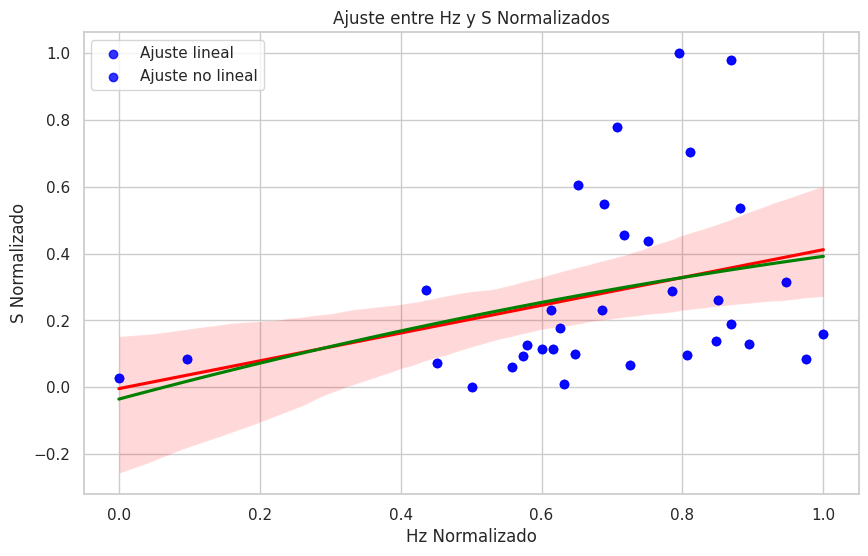

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Suponiendo que ya tienes clean_df definido

# Inicializar el escalador Min-Max
scaler = MinMaxScaler()

# Normalizar las columnas 'S' y 'Hz'
clean_df[['S_normalized', 'Hz_normalized']] = scaler.fit_transform(clean_df[['S', 'Hz']])

# Graficar la dispersión y el ajuste
plt.figure(figsize=(10, 6))

# Ajuste lineal
sns.regplot(x='Hz_normalized', y='S_normalized', data=clean_df, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'}, label='Ajuste lineal')

# Ajuste no lineal (ejemplo usando un polinomio de grado 2)
sns.regplot(x='Hz_normalized', y='S_normalized', data=clean_df, scatter_kws={'color': 'blue'}, line_kws={'color': 'green'},
            order=2, label='Ajuste no lineal', ci=None)

plt.title("Ajuste entre Hz y S Normalizados")
plt.xlabel("Hz Normalizado")
plt.ylabel("S Normalizado")
plt.legend()
plt.grid(True)
plt.show()


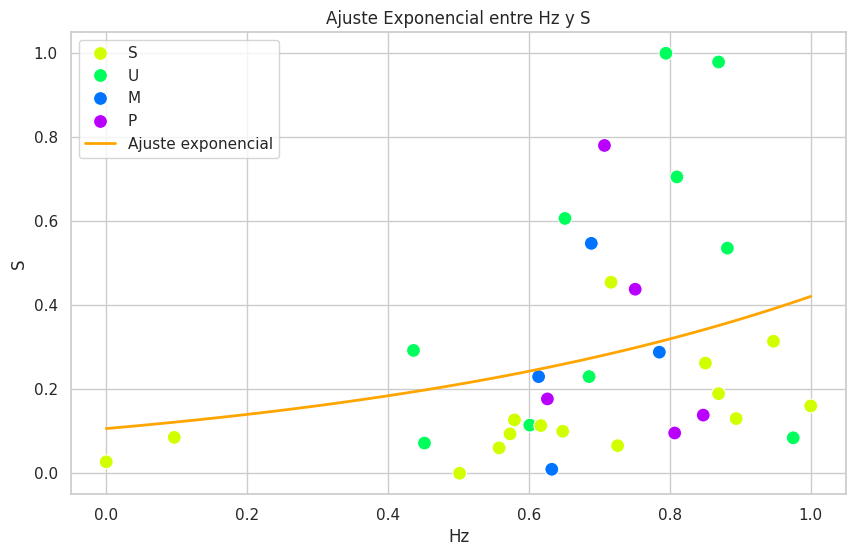

In [ ]:

from scipy.optimize import curve_fit

# Definir la función exponencial
def exp_func(x, a, b):
    return a * np.exp(b * x)

# Graficar la dispersión
plt.figure(figsize=(10, 6))

# Graficar los datos con colores según la clasificación en 'A'
palette = sns.color_palette("hsv", len(clean_df['A'].unique()))  # Color palette
sns.scatterplot(x='Hz', y='S', data=clean_df, hue='A', palette=palette, s=100)

# Ajuste exponencial
# Ajustar la función exponencial a los datos
params, covariance = curve_fit(exp_func, clean_df['Hz'], clean_df['S'], p0=(1, 0.1))

# Crear valores ajustados para graficar
x_fit = np.linspace(clean_df['Hz'].min(), clean_df['Hz'].max(), 100)  # Rango para la línea de ajuste
y_fit = exp_func(x_fit, *params)

# Graficar la línea de ajuste exponencial
plt.plot(x_fit, y_fit, color='orange', label='Ajuste exponencial', linewidth=2)

plt.title("Ajuste Exponencial entre Hz y S")
plt.xlabel("Hz")
plt.ylabel("S")
plt.legend()
plt.grid(True)
plt.show()



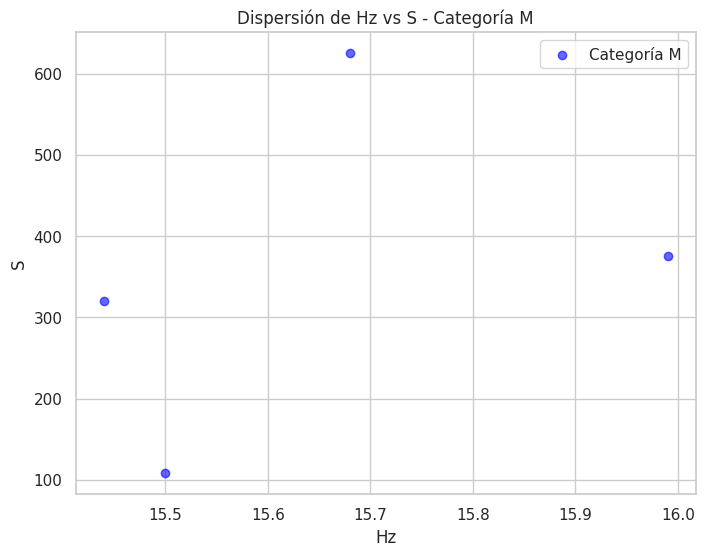

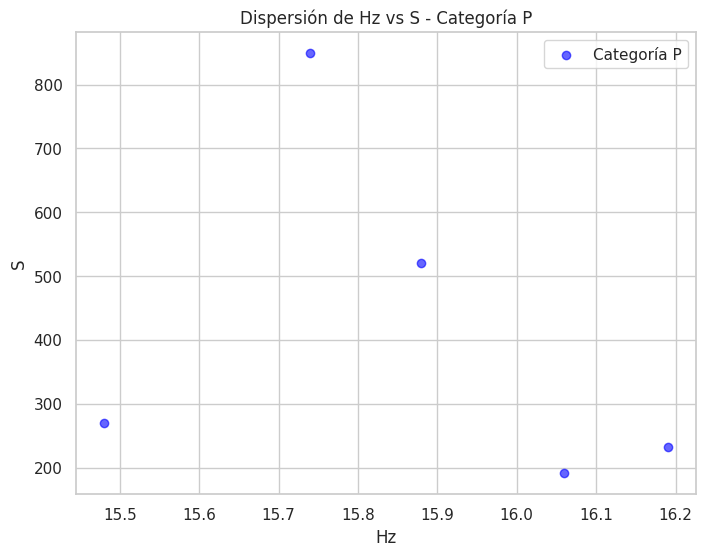

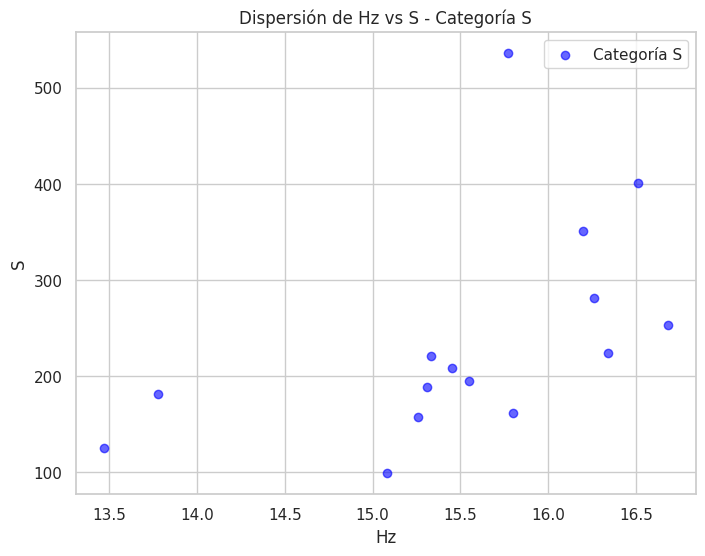

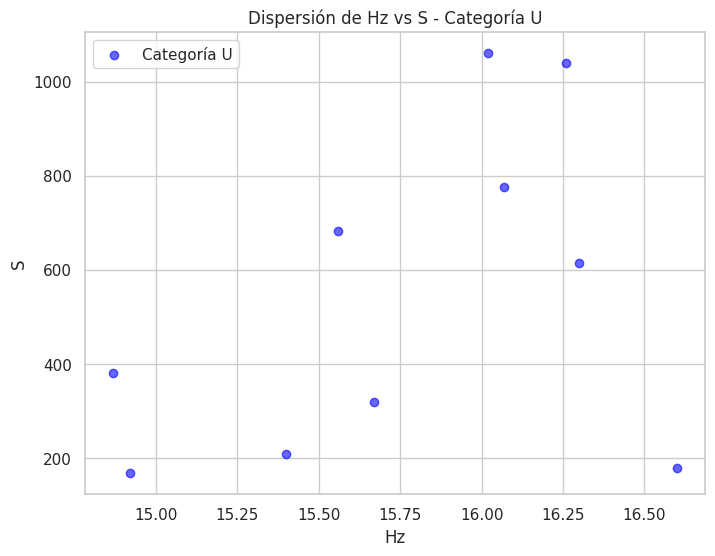

In [17]:
import matplotlib.pyplot as plt

# Agrupar el DataFrame por la categoría 'A'
grupos_A = clean_df.groupby('A')

# Iterar sobre cada grupo y hacer la gráfica de dispersión
for nombre_grupo, grupo in grupos_A:
    # Extraer las variables Hz y S para el grupo actual
    Hz = grupo['Hz']
    S = grupo['S']

    # Crear una figura separada para cada categoría
    plt.figure(figsize=(8, 6))

    # Graficar los puntos de dispersión para el grupo actual
    plt.scatter(Hz, S, label=f'Categoría {nombre_grupo}', alpha=0.6, color='blue')

    # Etiquetas y título para cada gráfico
    plt.xlabel('Hz')
    plt.ylabel('S')
    plt.title(f'Dispersión de Hz vs S - Categoría {nombre_grupo}')
    plt.legend()
    plt.grid(True)

    # Mostrar el gráfico
    plt.show()



Consideramos la densidad superficial de entropía Sx

---



In [ ]:
# Crear la columna de entropía superficial dentro de clean_df
clean_df['S_sup'] = clean_df['S'] / (np.pi * clean_df['R500']**2)

# Mostrar las primeras filas del dataframe para verificar
print(clean_df[['Nombre', 'S', 'R500', 'S_sup']].head())


                       Nombre       S    R500       S_sup
0  ABELL_0085                   281.0  1.2103   61.061909
1  ABELL_0119                   536.0  0.9413  192.556773
2  ABELL_0133                   195.0  0.9379   70.562128
3  ABELL_0399                   777.0  1.1169  198.263407
4  ABELL_0400                  1040.0  1.2421  214.570663


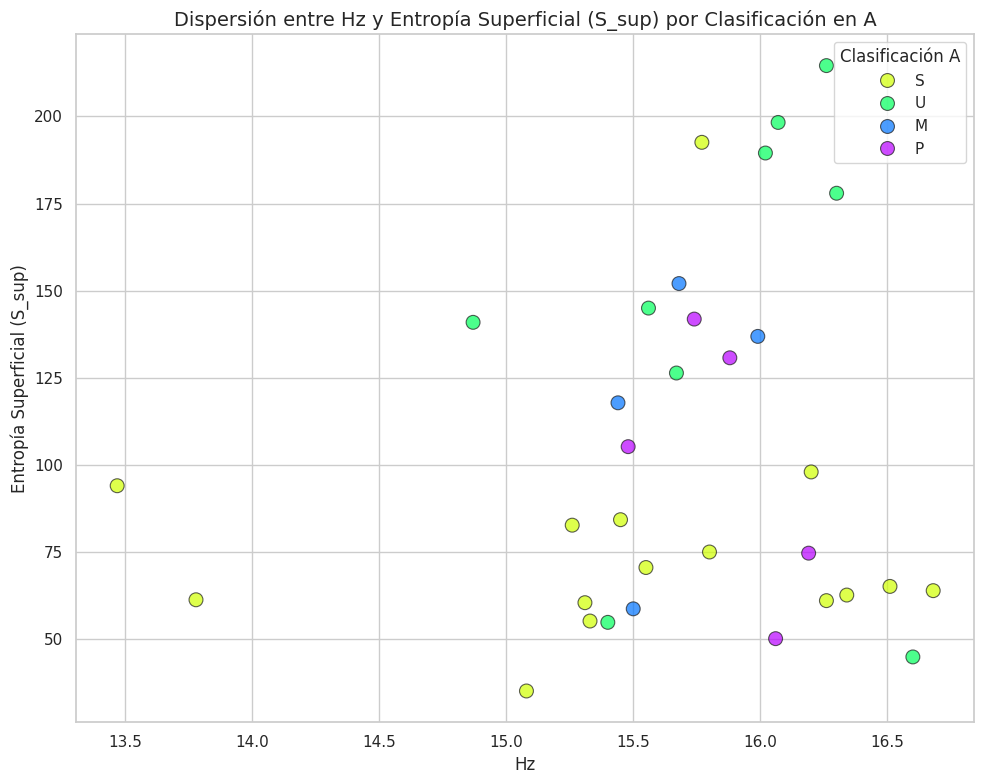

In [18]:
# Crear la columna de entropía superficial dentro de clean_df
clean_df['S_sup'] = clean_df['S'] / (np.pi * clean_df['R500']**2)

# Configurar una paleta de colores distinta para cada categoría en la columna 'A'
palette = sns.color_palette("hsv", len(clean_df['A'].unique()))

# Graficar la dispersión de Hz vs S_sup, con un color distinto por cada grupo de A
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Hz', y='S_sup', hue='A', data=clean_df, palette=palette, s=100, edgecolor='k', alpha=0.7)

# Personalizar la gráfica
plt.title('Dispersión entre Hz y Entropía Superficial (S_sup) por Clasificación en A', fontsize=14)
plt.xlabel('Hz', fontsize=12)
plt.ylabel('Entropía Superficial (S_sup)', fontsize=12)
plt.legend(title='Clasificación A')
plt.grid(True)

# Mostrar la gráfica
plt.tight_layout()
plt.show()


# **Considerando ambas densidades superficiales de entropía**

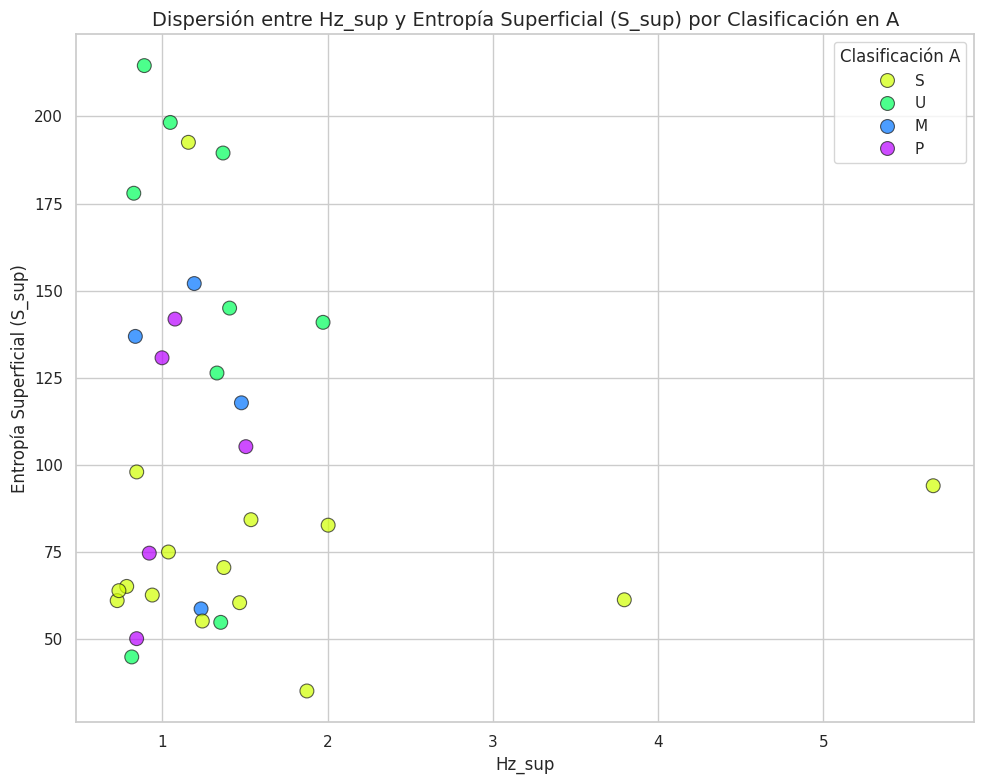

In [19]:
# Crear la columna de entropía superficial S_sup dentro de clean_df
clean_df['S_sup'] = clean_df['S'] / (np.pi * clean_df['R500']**2)

# Crear la columna de Hz superficial Hz_sup
clean_df['Hz_sup'] = clean_df['Hz'] / (np.pi * clean_df['Rvir']**2)

# Configurar una paleta de colores distinta para cada categoría en la columna 'A'
palette = sns.color_palette("hsv", len(clean_df['A'].unique()))

# Graficar la dispersión de Hz_sup vs S_sup, con un color distinto por cada grupo de A
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Hz_sup', y='S_sup', hue='A', data=clean_df, palette=palette, s=100, edgecolor='k', alpha=0.7)

# Personalizar la gráfica
plt.title('Dispersión entre Hz_sup y Entropía Superficial (S_sup) por Clasificación en A', fontsize=14)
plt.xlabel('Hz_sup', fontsize=12)
plt.ylabel('Entropía Superficial (S_sup)', fontsize=12)
plt.legend(title='Clasificación A')
plt.grid(True)

# Mostrar la gráfica
plt.tight_layout()
plt.show()

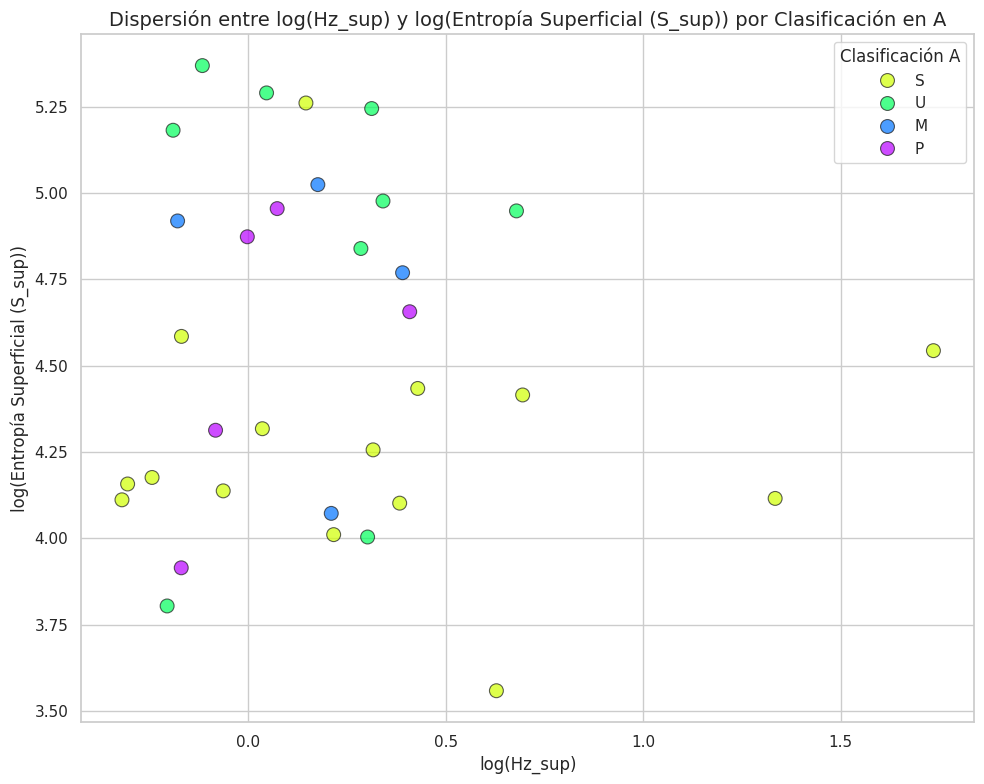

In [20]:
# Graficar la dispersión de log(S_sup) vs log(Hz_sup)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=np.log(clean_df['Hz_sup']), y=np.log(clean_df['S_sup']), hue='A', data=clean_df, palette=palette, s=100, edgecolor='k', alpha=0.7)

# Personalizar la gráfica
plt.title('Dispersión entre log(Hz_sup) y log(Entropía Superficial (S_sup)) por Clasificación en A', fontsize=14)
plt.xlabel('log(Hz_sup)', fontsize=12)
plt.ylabel('log(Entropía Superficial (S_sup))', fontsize=12)
plt.legend(title='Clasificación A')
plt.grid(True)

# Mostrar la gráfica
plt.tight_layout()
plt.show()


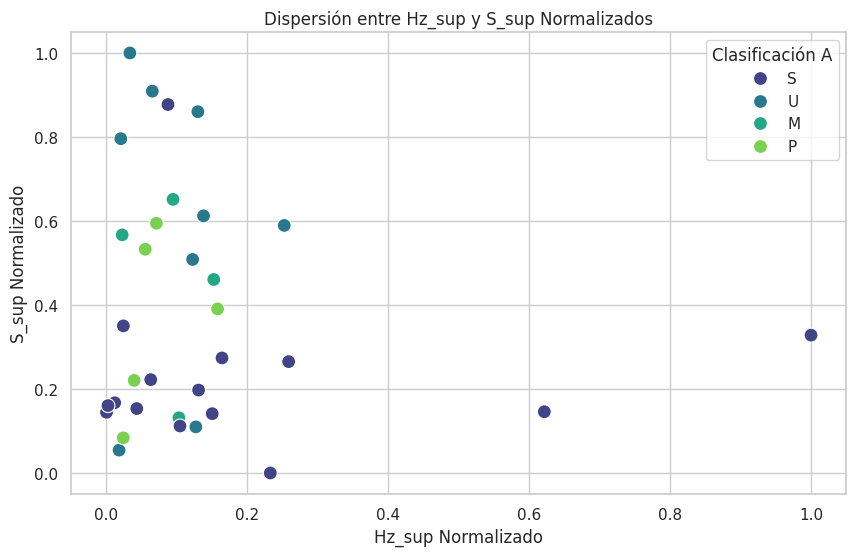

In [21]:
# Normalización de las entropías
clean_df['S_sup_normalized'] = (clean_df['S_sup'] - clean_df['S_sup'].min()) / (clean_df['S_sup'].max() - clean_df['S_sup'].min())
clean_df['Hz_sup_normalized'] = (clean_df['Hz_sup'] - clean_df['Hz_sup'].min()) / (clean_df['Hz_sup'].max() - clean_df['Hz_sup'].min())

# Graficar la dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(data=clean_df, x='Hz_sup_normalized', y='S_sup_normalized', hue='A', palette='viridis', s=100)

plt.title('Dispersión entre Hz_sup y S_sup Normalizados')
plt.xlabel('Hz_sup Normalizado')
plt.ylabel('S_sup Normalizado')
plt.legend(title='Clasificación A')
plt.show()


Eliminando valores extremos de Hz_sup

Cantidad de puntos después del filtrado: 32


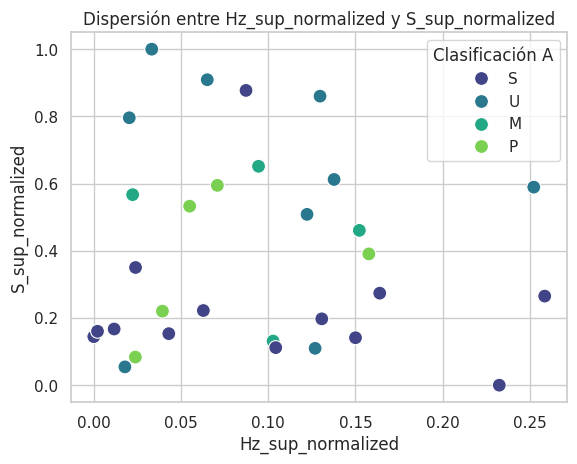

In [41]:
# Definir un nuevo umbral basado en los valores observados en 'Hz_sup_normalized'
threshold = 0.4  # Umbral para la versión normalizada (puede ajustarse según sea necesario)

# Filtrar el DataFrame basado en el umbral de Hz_sup_normalized
filtered_df = clean_df[clean_df['Hz_sup_normalized'] < threshold]

# Verificar cuántos puntos hay después del filtrado
print("Cantidad de puntos después del filtrado:", filtered_df.shape[0])

# Graficar la dispersión si hay puntos
if filtered_df.shape[0] > 0:
    sns.scatterplot(data=filtered_df, x='Hz_sup_normalized', y='S_sup_normalized', hue='A', palette='viridis', s=100)
    plt.xlabel('Hz_sup_normalized')
    plt.ylabel('S_sup_normalized')
    plt.title('Dispersión entre Hz_sup_normalized y S_sup_normalized')
    plt.legend(title='Clasificación A')
    plt.show()
else:
    print("No hay puntos para graficar después del filtrado.")



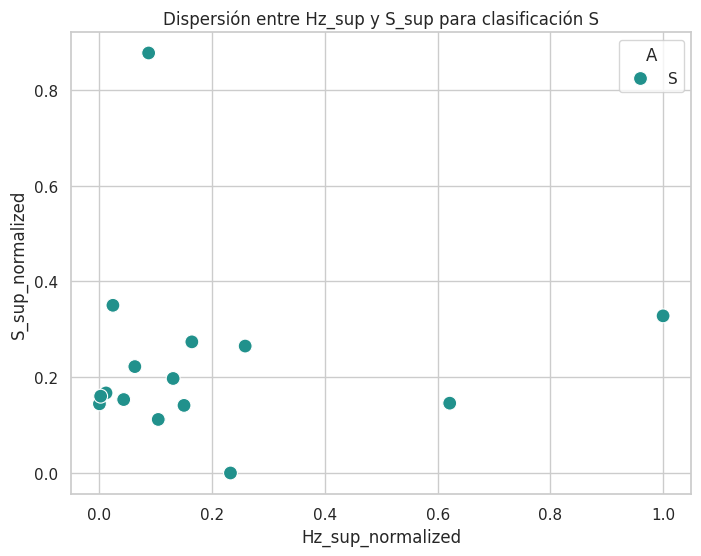

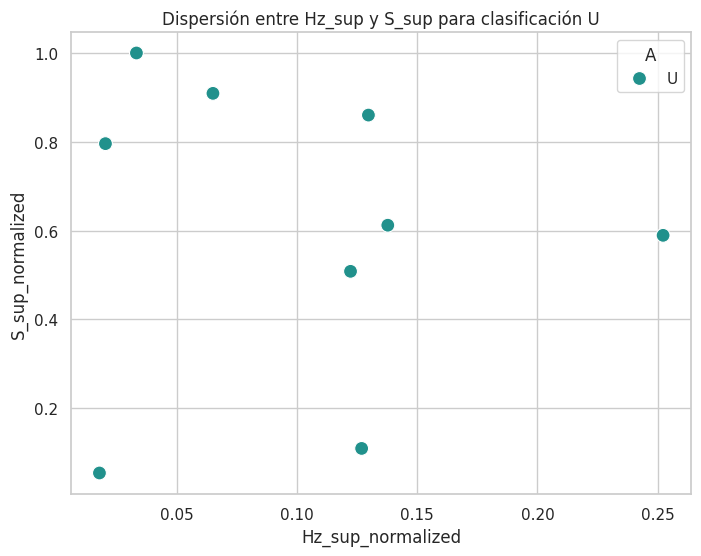

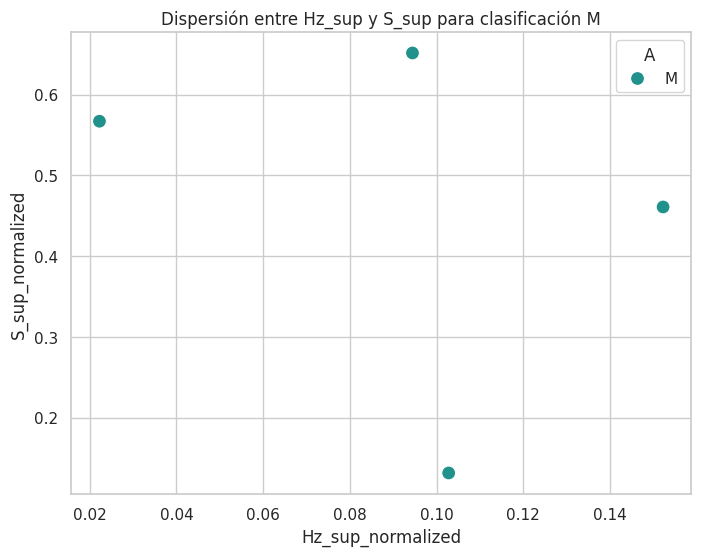

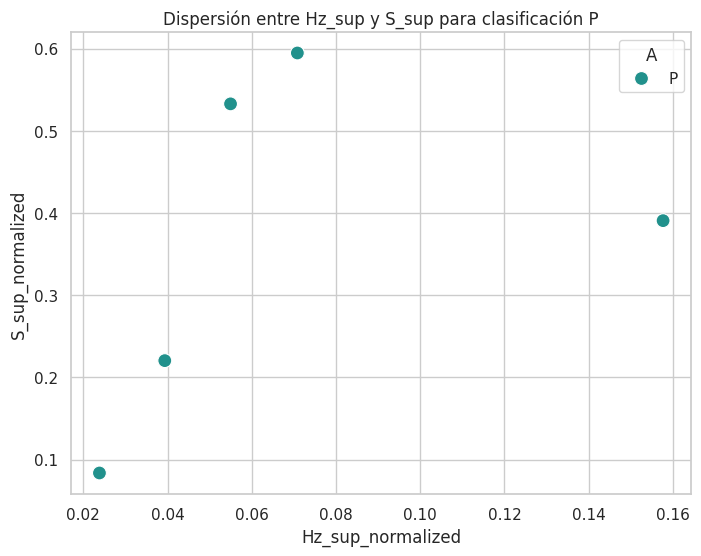

In [42]:
# Obtener las categorías únicas en la columna 'A'
categorias_A = clean_df['A'].unique()

# Graficar la dispersión por cada categoría en 'A'
for categoria in categorias_A:
    plt.figure(figsize=(8, 6))

    # Filtrar los datos para la categoría actual
    categoria_df = clean_df[clean_df['A'] == categoria]

    # Crear la gráfica de dispersión
    sns.scatterplot(data=categoria_df, x='Hz_sup_normalized', y='S_sup_normalized', hue='A', palette='viridis', s=100)

    # Etiquetas y título
    plt.xlabel('Hz_sup_normalized')
    plt.ylabel('S_sup_normalized')
    plt.title(f'Dispersión entre Hz_sup y S_sup para clasificación {categoria}')

    # Mostrar la gráfica
    plt.show()


# **Dispersion entre Hz y S, considerando su clasificacion segun CC**
---



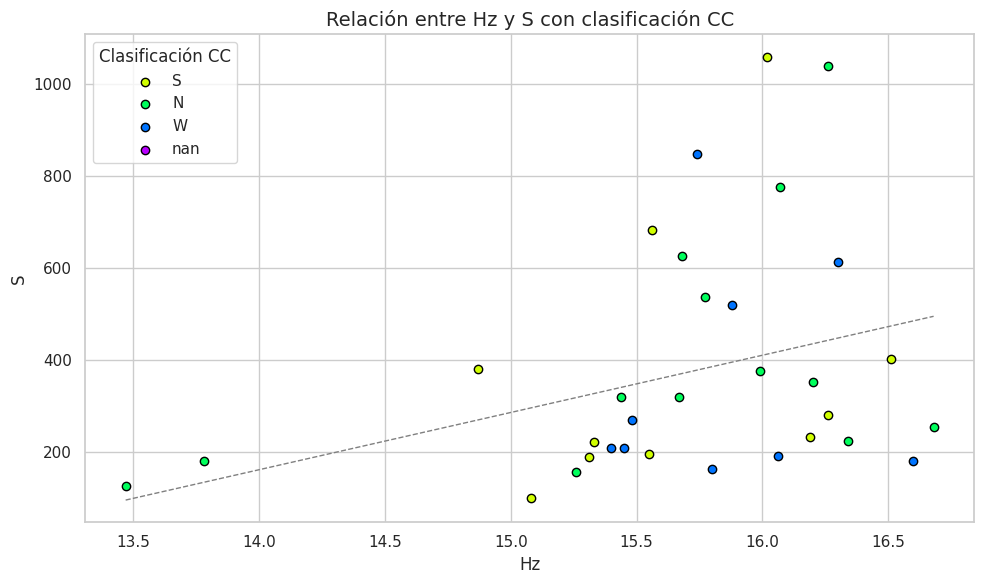

In [44]:
## Configuración del estilo de seaborn
sns.set(style="whitegrid")

# Crear un mapa de colores basado en las categorías de la primera letra de CC
unique_classes_CC = clean_df['CC'].str[0].unique()  # obtener las clases únicas de la primera letra de CC
palette = sns.color_palette("hsv", len(unique_classes_CC))  # generar una paleta de colores

# Crear la gráfica de dispersión
plt.figure(figsize=(10, 6))

for i, class_label in enumerate(unique_classes_CC):
    # Filtrar los datos por cada clase de CC
    class_data = clean_df[clean_df['CC'].str[0] == class_label]

    # Graficar la dispersión para cada clase
    plt.scatter(class_data['Hz'], class_data['S'], label=class_label,
                color=palette[i], edgecolor='black')

# Ajuste lineal con Seaborn (opcional)
sns.regplot(x='Hz', y='S', data=clean_df, scatter=False, color='gray', ci=None,
            line_kws={"linewidth":1, "linestyle":"--"})

# Configurar el título y etiquetas
plt.title('Relación entre Hz y S con clasificación CC', fontsize=14)
plt.xlabel('Hz', fontsize=12)
plt.ylabel('S', fontsize=12)

# Mostrar la leyenda
plt.legend(title='Clasificación CC')

# Mostrar la gráfica
plt.tight_layout()
plt.show()


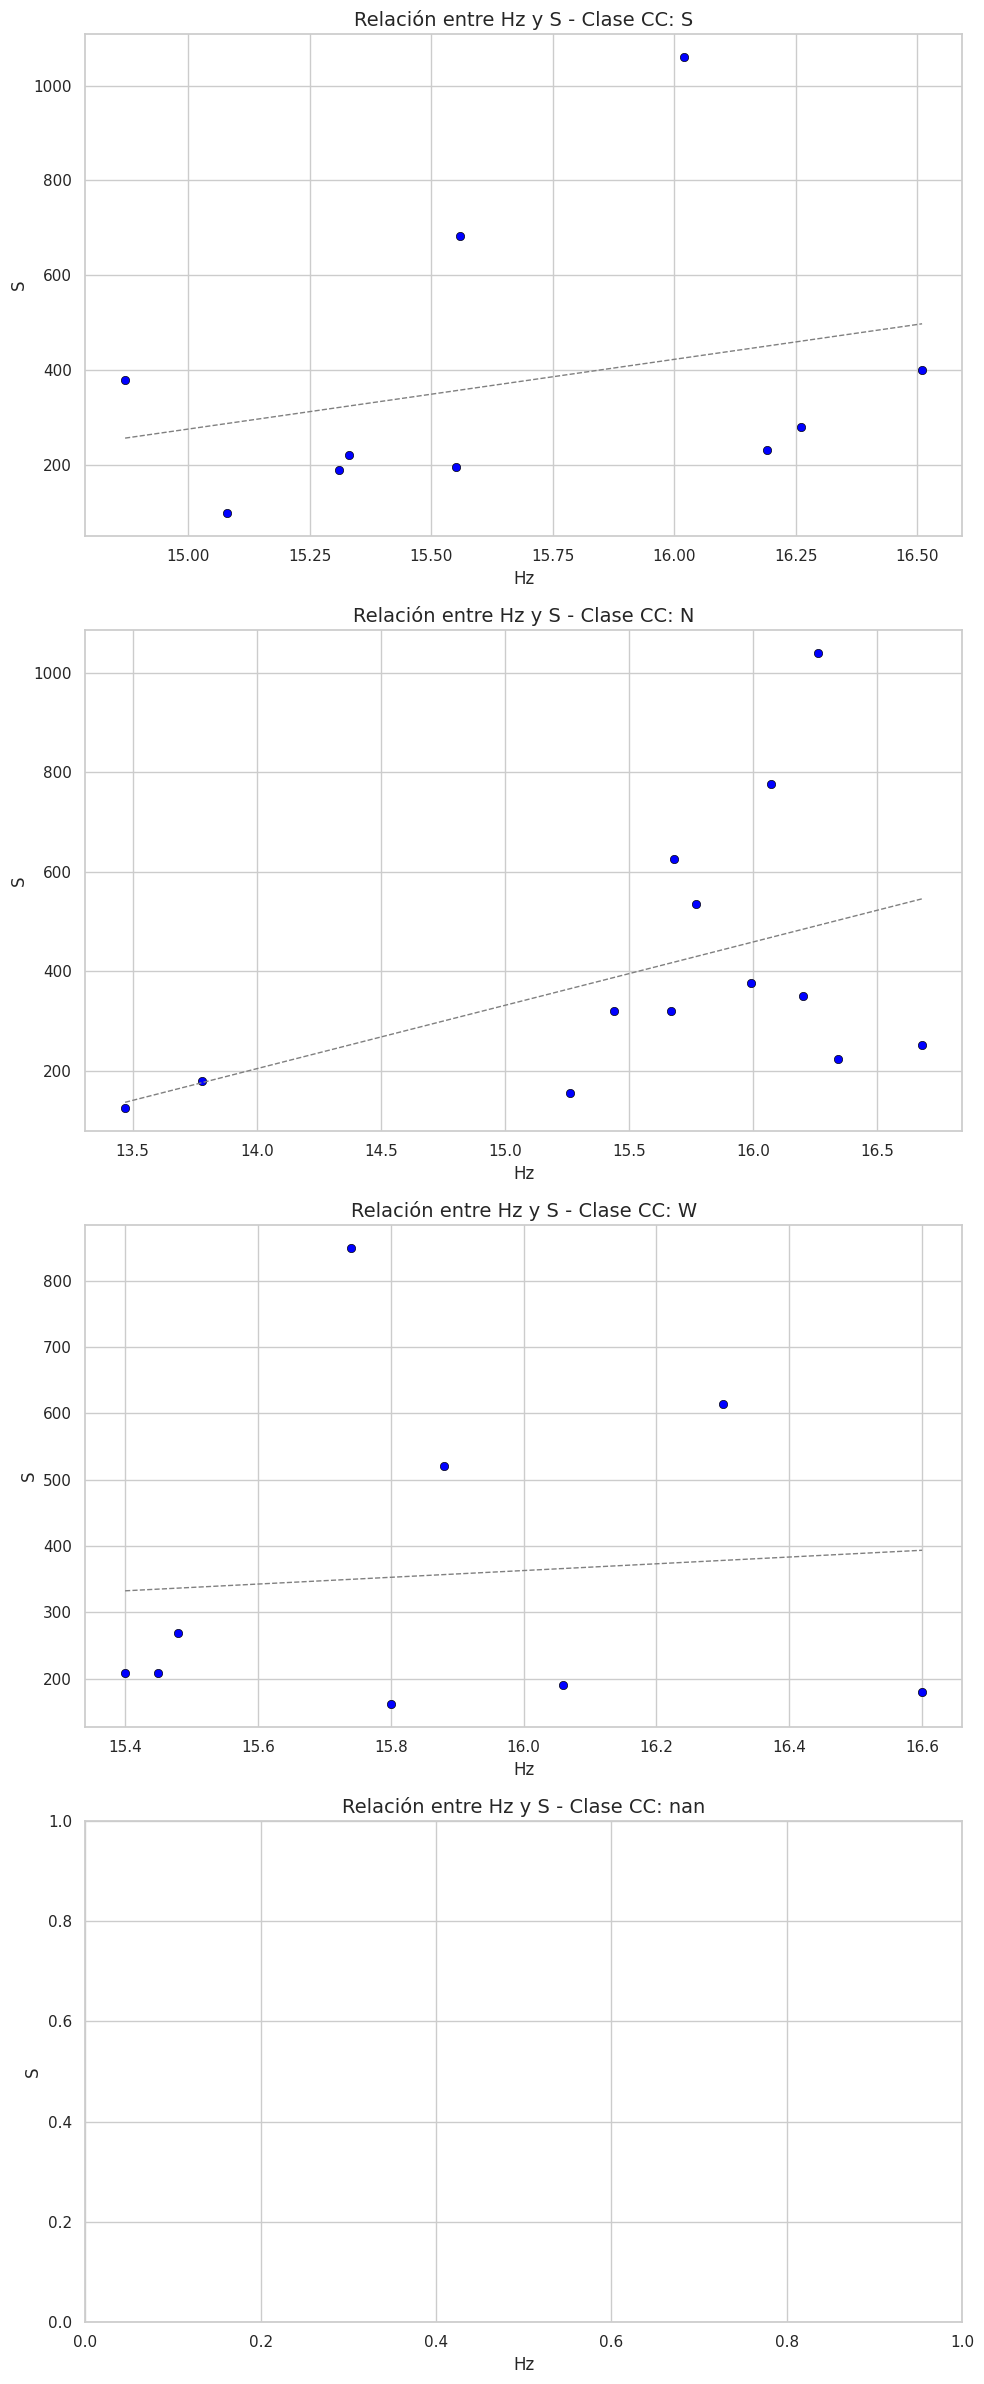

In [45]:
# Configuración del estilo de seaborn
sns.set(style="whitegrid")

# Obtener las clases únicas de la primera letra de CC
unique_classes_CC = clean_df['CC'].str[0].unique()

# Crear una figura para múltiples subgráficas
fig, axes = plt.subplots(nrows=len(unique_classes_CC), ncols=1, figsize=(10, 6 * len(unique_classes_CC)))
fig.subplots_adjust(hspace=0.4)

# Iterar sobre cada clase única
for i, class_label in enumerate(unique_classes_CC):
    # Filtrar los datos por cada clase de CC
    class_data = clean_df[clean_df['CC'].str[0] == class_label]

    # Graficar la dispersión para cada clase
    sns.scatterplot(x='Hz', y='S', data=class_data, ax=axes[i], color='blue', edgecolor='black')

    # Ajuste lineal (opcional)
    sns.regplot(x='Hz', y='S', data=class_data, ax=axes[i], scatter=False, color='gray', ci=None,
                line_kws={"linewidth": 1, "linestyle": "--"})

    # Configurar título y etiquetas
    axes[i].set_title(f'Relación entre Hz y S - Clase CC: {class_label}', fontsize=14)
    axes[i].set_xlabel('Hz', fontsize=12)
    axes[i].set_ylabel('S', fontsize=12)

# Mostrar la gráfica
plt.tight_layout()
plt.show()


Considerando las densidades de entropías superificiales

> Añadir blockquote



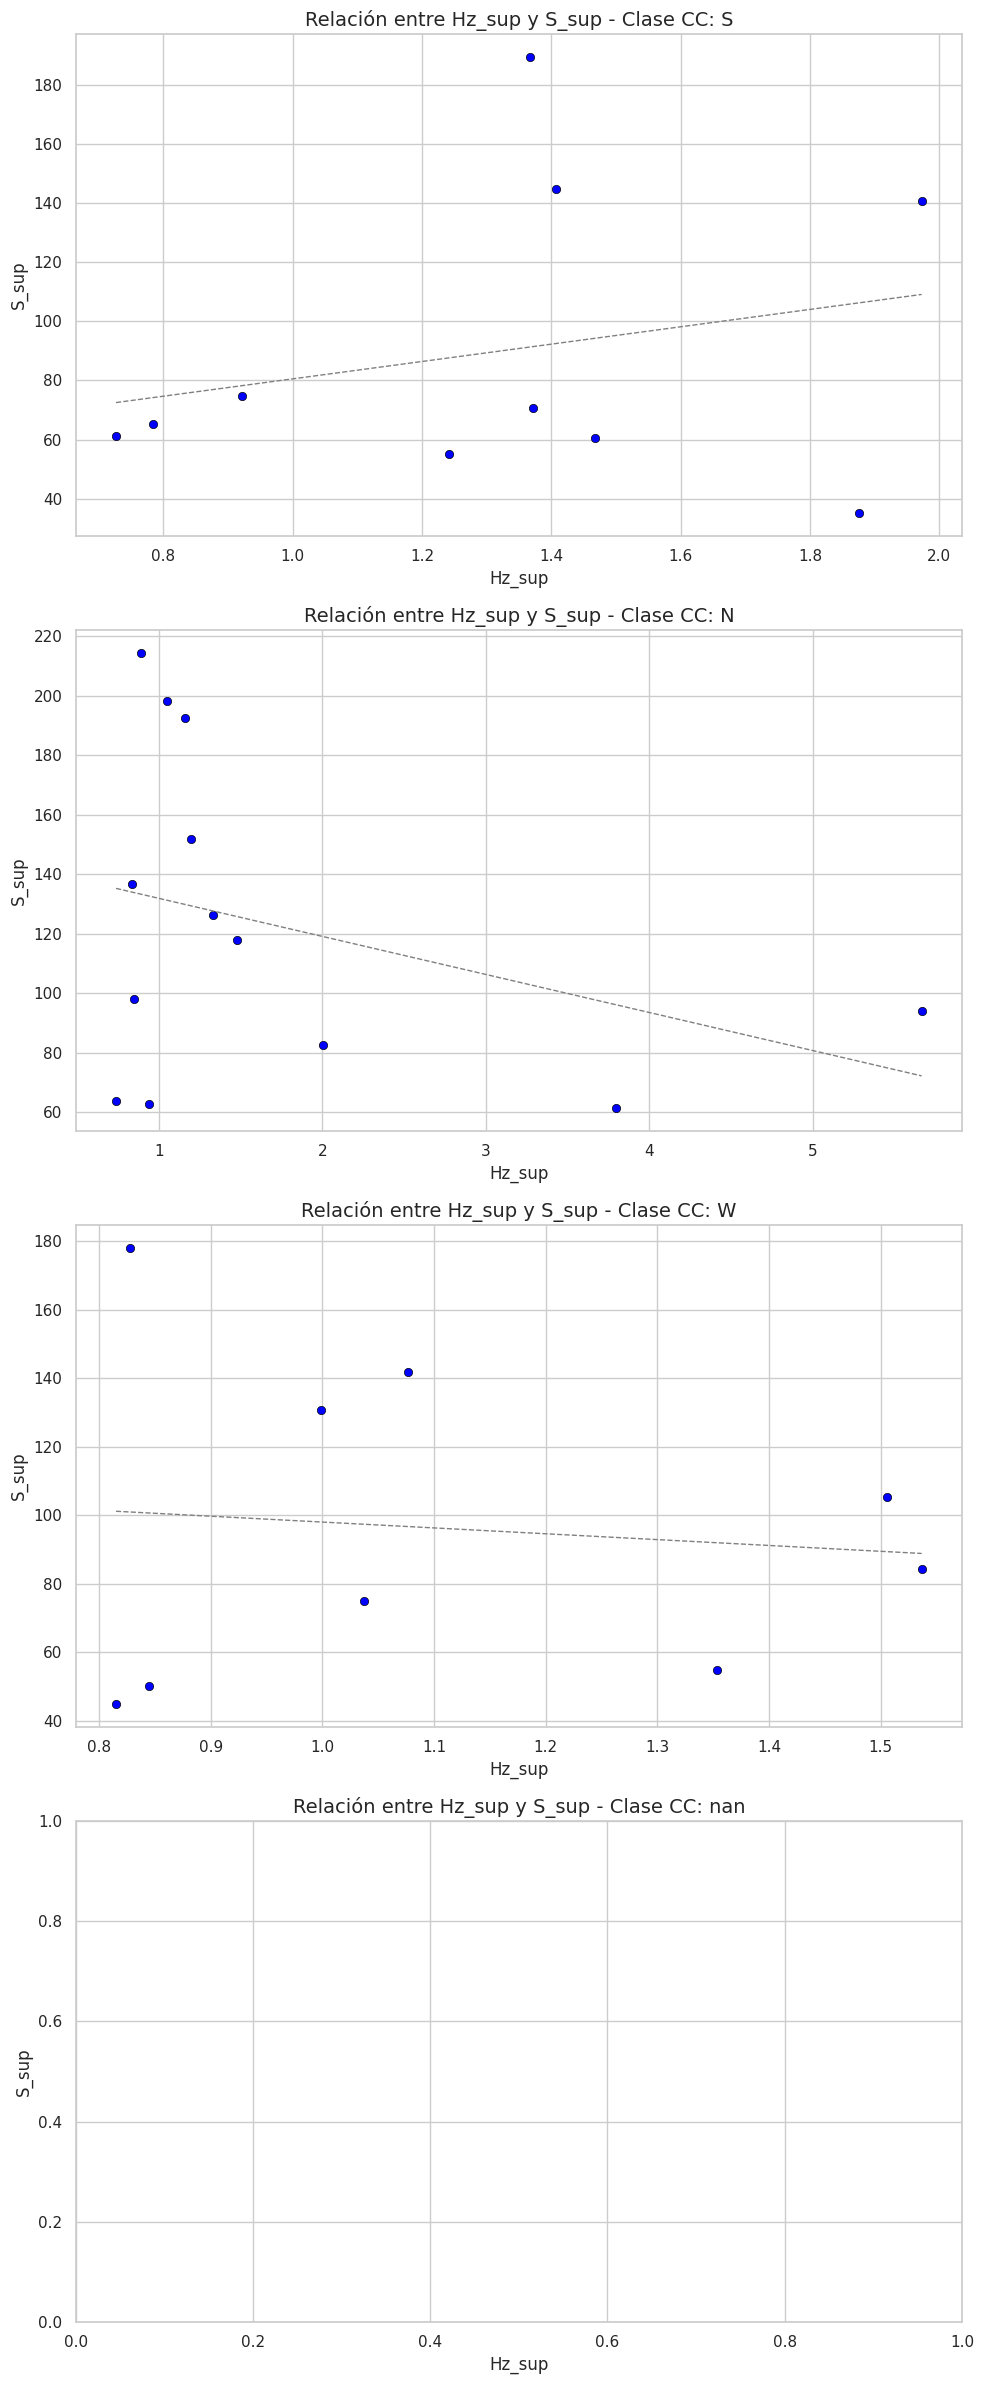

In [46]:
# Configuración del estilo de seaborn
sns.set(style="whitegrid")

# Obtener las clases únicas de la primera letra de CC
unique_classes_CC = clean_df['CC'].str[0].unique()

# Crear una figura para múltiples subgráficas
fig, axes = plt.subplots(nrows=len(unique_classes_CC), ncols=1, figsize=(10, 6 * len(unique_classes_CC)))
fig.subplots_adjust(hspace=0.4)

# Iterar sobre cada clase única
for i, class_label in enumerate(unique_classes_CC):
    # Filtrar los datos por cada clase de CC
    class_data = clean_df[clean_df['CC'].str[0] == class_label]

    # Graficar la dispersión para cada clase usando S_sup y Hz_sup
    sns.scatterplot(x='Hz_sup', y='S_sup', data=class_data, ax=axes[i], color='blue', edgecolor='black')

    # Ajuste lineal (opcional)
    sns.regplot(x='Hz_sup', y='S_sup', data=class_data, ax=axes[i], scatter=False, color='gray', ci=None,
                line_kws={"linewidth": 1, "linestyle": "--"})

    # Configurar título y etiquetas
    axes[i].set_title(f'Relación entre Hz_sup y S_sup - Clase CC: {class_label}', fontsize=14)
    axes[i].set_xlabel('Hz_sup', fontsize=12)
    axes[i].set_ylabel('S_sup', fontsize=12)

# Mostrar la gráfica
plt.tight_layout()
plt.show()
